# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
%load_ext autoreload
%autoreload 2

from unityagents import UnityEnvironment
import numpy as np

In [7]:
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='ReacherSingle_Windows_x86_64/Reacher.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [12]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33


### 4. Training

#### Reset the environment and retrieve information

In [8]:
# Reset the environment and retrieve information
env_info = env.reset(train_mode=True)[brain_name]
num_agents = len(env_info.agents)
action_size = brain.vector_action_space_size
states = env_info.vector_observations
state_size = states.shape[1]

#### Define workflow functions

In [9]:
def GameUpdate(states, actions):
    env_info = env.step(actions)[brain_name]           # send the action to the environment
    num_agents = len(env_info.agents)
    next_states = env_info.vector_observations      # get the next state
    rewards = env_info.rewards                      # get the reward
    dones = env_info.local_done                     # see if episode has finished
    
    return [(states[i], actions[i], rewards[i], next_states[i], dones[i]) for i in range(num_agents)]

def DisplayScore(scores, running_average=100, title=""):
    N = len(scores)
    avg = [sum(scores[i:i+running_average])/running_average for i in range(N - running_average)]
    
    plt.figure(figsize=(15,5))
    plt.plot(np.arange(N),scores)
    plt.plot(np.arange(running_average, N), avg)
    plt.xlabel("Episode")
    plt.ylabel("Score")
    plt.suptitle(title)
    plt.show()

#### Define Training

In [10]:
from Source.Agents import DDPG_Agent
from Source.Network import DDPG_Actor, DDPG_Critic
from Source.Buffers import Buffer

def DDPG(n_episodes=500, max_t=1000, print_every=100, learn_every=20, score_window=100, success_score=30):
    scores_window = deque(maxlen=score_window)
    scores = []
    
    # Create Actor and Critic Networks
    actor_network  = DDPG_Actor( state_size, action_size, fc1_units=400, fc2_units=200, device=device, learning_rate=1e-3)
    critic_network = DDPG_Critic(state_size, action_size, fc1_units=400, fc2_units=200, weight_decay=0, device=device, learning_rate=1e-3)
    
    # Define Buffer
    buffer = Buffer(buffer_size=1e6, batch_size=1024, seed=1234)
    
    # Define the agent
    agents = [DDPG_Agent(state_size     = state_size, 
                         action_size    = action_size,
                         actor_network  = actor_network,
                         critic_network = critic_network,
                         replay_buffer  = buffer,
                         device         = device) for _ in range(num_agents)]
    
    for episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        ep_scores = [0] * num_agents
        
        for agent in agents:
            agent.episode_start()
        
        # ==== START EPISODE ====
        
        for t in range(max_t):
            # Retrieve action for every agent
            actions = [agent.act(state) for agent, state in zip(agents, states)]
            
            # Compute one game frame
            results = GameUpdate(states, actions)
            
            # Compute a step for every agent
            i = 0
            for agent, data in zip(agents,results):
                state, action, reward, next_state, done = data
                agent.step(state, action, reward, next_state, done)
                ep_scores[i] += reward
                i += 1
            
            # Learn when appropiate
            if t % learn_every == 0:
                for agent in agents:
                    agent.learn()
                
            # Check if the episode has ended
            if all([result[-1] for result in results]):
                break
                
            # State transition
            states = [next_state for state, action, reward, next_state, done in results]
        
        # ==== END EPISODE ====
        for agent in agents:
            agent.episode_end()
        
        
        # Update Scores
        mean_score = np.mean(ep_scores)
        scores.append(mean_score)
        scores_window.append(mean_score)
        
        mean_window = np.mean(scores_window) if len(scores_window) > 0 else 0 
        
        # Checkpoint Networks
        agent.save("Models", "DDPG")
        
        # Verbose Information
        if episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}               '.format(episode, mean_window))
        else:
            print('\rEpisode {}\tAverage Score: {:.2f} | Last: {:.2f}'.format(episode, mean_window, mean_score), end="")
              
        if mean_window > success_score:
            print("\r[Solved] Episode {}\tAverage Score: {:.2f}       ".format(episode, mean_window))
            break
            
    return scores

#### Train and display results

Episode 100	Average Score: 0.72               
Episode 200	Average Score: 2.12               
Episode 300	Average Score: 5.27               
Episode 400	Average Score: 11.24               
Episode 500	Average Score: 17.36               
Episode 600	Average Score: 24.57               
Episode 700	Average Score: 29.07               
[Solved] Episode 730	Average Score: 30.0534.89


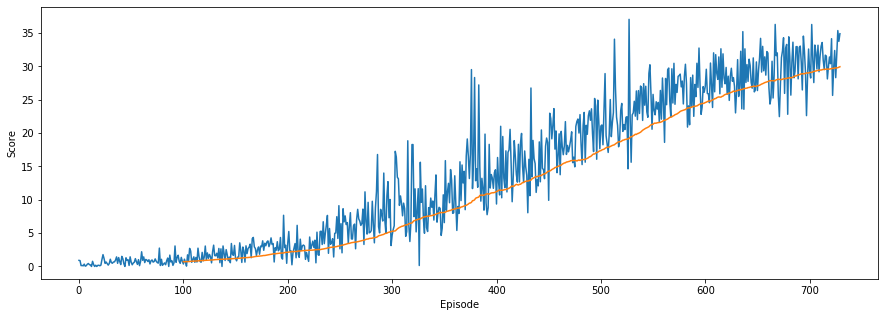

In [11]:
scores = DDPG(n_episodes=1000)
DisplayScore(scores)

## 5. Close Environment

In [13]:
env.close()